# EDA Analysis and model experimentation #

In [13]:
# Importing libraries
import os
import pandas as pd
import numpy as np
from pathlib import Path
import re

from data_preloader import config
import matplotlib.pyplot as plt
import seaborn as sns
import data_preloader.text_preprocessing as tp

import openai
import pandas as pd
import boto3
import langchain

# Importing ENV Variables

In [14]:
from dotenv import load_dotenv
load_dotenv

<function dotenv.main.load_dotenv(dotenv_path: Union[str, ForwardRef('os.PathLike[str]'), NoneType] = None, stream: Optional[IO[str]] = None, verbose: bool = False, override: bool = False, interpolate: bool = True, encoding: Optional[str] = 'utf-8') -> bool>

In [15]:
OPEN_AI_API_KEY = os.getenv('OPEN_AI_API_KEY') # API key for OpenAI
AWS_S3= os.getenv('AWS_S3')
AWS_S3_SECRET = os.getenv('AWS_S3_SECRET')

## Instanciating a connection to S3 with credentials

In [16]:

s3 = boto3.client('s3', 
                  aws_access_key_id=AWS_S3, 
                  aws_secret_access_key=AWS_S3_SECRET
                  )


## Getting the files filter by prefix

In [17]:


prefix = 'queplan_insurance/'
bucket_name = 'anyoneai-datasets'   
maxkeys = 9999999
s3 = boto3.client('s3')
list=s3.list_objects(Bucket=bucket_name, Prefix=prefix, MaxKeys = maxkeys)['Contents']
list_keys = []
list_filepath = []
dataset_path = str(Path(config.DATASET_ROOT_PATH) / "raw_pdfs")

for s3_key in list:
    s3_object = s3_key['Key']
    
    path, filename = os.path.split(s3_object)
    
    filepath = os.path.join(dataset_path, filename)
    list_filepath.append(filepath) 
    list_keys.append(s3_object)

In [18]:
s3 = boto3.resource(
    "s3",
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY"),
    aws_secret_access_key=os.getenv("AWS_SECRET_KEY"),
)
bucket = s3.Bucket("anyoneai-datasets")
objects = bucket.objects.filter(Prefix=prefix)
size_byte = 0
counter = 0
for obj in objects:
    size_byte += obj.size
    counter += 1
print(f"Total dataset size: {round(size_byte/1000/1024/1024, 2)} GB")
print(f"Total documents: {counter}")

Total dataset size: 0.0 GB
Total documents: 10


In [19]:
list_filepath

['/home/andy/Insync/anvasquezre@unal.edu.co/Google Drive/ML_AI/AnyoneAI/06_Final_Project/model_experiments/data_preloader/dataset/raw_pdfs/',
 '/home/andy/Insync/anvasquezre@unal.edu.co/Google Drive/ML_AI/AnyoneAI/06_Final_Project/model_experiments/data_preloader/dataset/raw_pdfs/POL120190177.pdf',
 '/home/andy/Insync/anvasquezre@unal.edu.co/Google Drive/ML_AI/AnyoneAI/06_Final_Project/model_experiments/data_preloader/dataset/raw_pdfs/POL320130223.pdf',
 '/home/andy/Insync/anvasquezre@unal.edu.co/Google Drive/ML_AI/AnyoneAI/06_Final_Project/model_experiments/data_preloader/dataset/raw_pdfs/POL320150503.pdf',
 '/home/andy/Insync/anvasquezre@unal.edu.co/Google Drive/ML_AI/AnyoneAI/06_Final_Project/model_experiments/data_preloader/dataset/raw_pdfs/POL320180100.pdf',
 '/home/andy/Insync/anvasquezre@unal.edu.co/Google Drive/ML_AI/AnyoneAI/06_Final_Project/model_experiments/data_preloader/dataset/raw_pdfs/POL320190074.pdf',
 '/home/andy/Insync/anvasquezre@unal.edu.co/Google Drive/ML_AI/Anyon

In [20]:
list_keys

['queplan_insurance/',
 'queplan_insurance/POL120190177.pdf',
 'queplan_insurance/POL320130223.pdf',
 'queplan_insurance/POL320150503.pdf',
 'queplan_insurance/POL320180100.pdf',
 'queplan_insurance/POL320190074.pdf',
 'queplan_insurance/POL320200071.pdf',
 'queplan_insurance/POL320200214.pdf',
 'queplan_insurance/POL320210063.pdf',
 'queplan_insurance/POL320210210.pdf']

## Downloading the specific files by prefix 'queplan_insurance'

In [21]:
s3 = boto3.resource('s3')

for key,path in zip(list_keys[1:],list_filepath[1:]):
    if os.path.exists(path):
        print(f"File already downloaded: {path}")
    else:
        s3.meta.client.download_file(bucket_name, key,path)

File already downloaded: /home/andy/Insync/anvasquezre@unal.edu.co/Google Drive/ML_AI/AnyoneAI/06_Final_Project/model_experiments/data_preloader/dataset/raw_pdfs/POL120190177.pdf
File already downloaded: /home/andy/Insync/anvasquezre@unal.edu.co/Google Drive/ML_AI/AnyoneAI/06_Final_Project/model_experiments/data_preloader/dataset/raw_pdfs/POL320130223.pdf
File already downloaded: /home/andy/Insync/anvasquezre@unal.edu.co/Google Drive/ML_AI/AnyoneAI/06_Final_Project/model_experiments/data_preloader/dataset/raw_pdfs/POL320150503.pdf
File already downloaded: /home/andy/Insync/anvasquezre@unal.edu.co/Google Drive/ML_AI/AnyoneAI/06_Final_Project/model_experiments/data_preloader/dataset/raw_pdfs/POL320180100.pdf
File already downloaded: /home/andy/Insync/anvasquezre@unal.edu.co/Google Drive/ML_AI/AnyoneAI/06_Final_Project/model_experiments/data_preloader/dataset/raw_pdfs/POL320190074.pdf
File already downloaded: /home/andy/Insync/anvasquezre@unal.edu.co/Google Drive/ML_AI/AnyoneAI/06_Final_P

Checking the name of the downloaded pdfs

In [22]:
pdf_list = os.listdir(str(Path(config.DATASET_ROOT_PATH) /  "raw_pdfs"))

list_docs = []
pdf_list


['POL320150503.pdf',
 'POL320190074.pdf',
 'POL320210063.pdf',
 'POL320180100.pdf',
 'POL320210210.pdf',
 'POL320130223.pdf',
 'POL320200214.pdf',
 'POL320200071.pdf',
 'POL120190177.pdf']

# Testing Loaders

## PymuPDF

In [23]:
from langchain.document_loaders import PyMuPDFLoader

for pdf in pdf_list:
    loader_pymu = PyMuPDFLoader(f"{config.DATASET_ROOT_PATH}/raw_pdfs/{pdf}")  # Load the document
    pages_pymu = loader_pymu.load()
    list_docs.append(pages_pymu)

In [24]:
list_docs

[[Document(page_content='PÓLIZA DE SEGURO PARA PRESTACIONES MÉDICAS DERIVADAS DE ACCIDENTE\nY ENFERMEDAD\nIncorporada al Depósito de Pólizas bajo el código POL320150503\nARTÍCULO 1°: REGLAS APLICABLES AL CONTRATO\n \nSe aplicarán al presente contrato de seguro las disposiciones contenidas en los artículos siguientes y las\nnormas legales de carácter imperativo establecidas en el artículo VIII, del Libro II, del Código de Comercio.\nSin embargo, se entenderán válidas las estipulaciones contractuales que sean más beneficiosas para el\nasegurado o el beneficiario.\n \nARTÍCULO 2º: COBERTURA Y MATERIA ASEGURADA\n \nLa Compañía Aseguradora reembolsará al asegurado o pagará directamente al prestador de salud los\nGastos Médicos Razonables y Acostumbrados y Efectivamente Incurridos, una vez otorgada y pagada la\ncobertura del sistema de salud previsional, seguros complementarios u otros beneficios contratados por el\nasegurado. Lo anterior, cuando al asegurado se le diagnostique por primera v

PymuPDF creates complete document metadata and creates a Document class per each page but does not applies any text normalization by default, e.g , does not replaces consecutive  ```\n\n\n\n ``` for ```\n\n ```

In [25]:
from langchain.document_loaders import DirectoryLoader

loader_dl = DirectoryLoader("dataset/raw_pdfs/")
pages_dl = loader_dl.load()

In [26]:
pages_dl

[Document(page_content='PÓLIZA DE SEGURO PARA PRESTACIONES MÉDICAS DERIVADAS DE ACCIDENTE\n\nY ENFERMEDAD\n\nIncorporada al Depósito de Pólizas bajo el código POL320150503\n\nARTÍCULO 1°: REGLAS APLICABLES AL CONTRATO\n\nSe aplicarán al presente contrato de seguro las disposiciones contenidas en los artículos siguientes y las normas legales de carácter imperativo establecidas en el artículo VIII, del Libro II, del Código de Comercio. Sin embargo, se entenderán válidas las estipulaciones contractuales que sean más beneficiosas para el asegurado o el beneficiario.\n\nARTÍCULO 2º: COBERTURA Y MATERIA ASEGURADA\n\nLa Compañía Aseguradora reembolsará al asegurado o pagará directamente al prestador de salud los Gastos Médicos Razonables y Acostumbrados y Efectivamente Incurridos, una vez otorgada y pagada la cobertura del sistema de salud previsional, seguros complementarios u otros beneficios contratados por el asegurado. Lo anterior, cuando al asegurado se le diagnostique por primera vez u

Directory Loader instead creates a Document class per document in the folder, applies some text normalization to consecutive new line simbols and spaces, but the metadata is not as complete as PymuPDF

### Tokens exploration
Now, lets check the tokens in each Doc class created by Directory loader. The PymuPDF even though creates more information, we have a dataset that still needs preprocessing due to new line symbols and repeated information, thus splitting by pages is not a good idea yet. Further down the document we are going to study each document for repeated or multiple policies 

#### Directory loader

In [27]:
import tiktoken

MODEL = "gpt-3.5-turbo"

encoder = tiktoken.encoding_for_model(MODEL)


tokens_dict = {}
for page in pages_dl:
    num_tokens = len(encoder.encode(page.page_content))
    tokens_dict[page.metadata["source"]] = num_tokens
    
tokens_dict


{'dataset/raw_pdfs/POL320150503.pdf': 16949,
 'dataset/raw_pdfs/POL320190074.pdf': 28058,
 'dataset/raw_pdfs/POL320210063.pdf': 4192,
 'dataset/raw_pdfs/POL320180100.pdf': 15782,
 'dataset/raw_pdfs/POL320210210.pdf': 6838,
 'dataset/raw_pdfs/POL320130223.pdf': 13783,
 'dataset/raw_pdfs/POL320200214.pdf': 27308,
 'dataset/raw_pdfs/POL320200071.pdf': 23280,
 'dataset/raw_pdfs/POL120190177.pdf': 16037}

<Axes: ylabel='Count'>

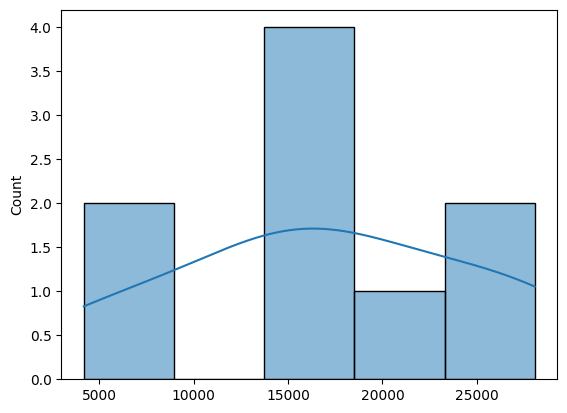

In [28]:
sns.histplot(pd.Series(tokens_dict.values()), kde=True)

# Data Exploration by Regex

## Checking special chars removel effect on total char length

In [29]:
# Removing special characters
text_wo_char = tp.normalize_corpus([pages_dl[0].page_content], special_char_removal=True, stopword_removal=False, remove_digits=False)
text_wo_char , len(text_wo_char[0])

(['poliza de seguro para prestaciones medicas derivadas de accidente\n\ny enfermedad\n\nincorporada al deposito de polizas bajo el codigo pol320150503\n\narticulo 1 reglas aplicables al contrato\n\nse aplicaran al presente contrato de seguro las disposiciones contenidas en los articulos siguientes y las normas legales de caracter imperativo establecidas en el articulo viii del libro ii del codigo de comercio sin embargo se entenderan validas las estipulaciones contractuales que sean mas beneficiosas para el asegurado o el beneficiario\n\narticulo 2o cobertura y materia asegurada\n\nla compania aseguradora reembolsara al asegurado o pagara directamente al prestador de salud los gastos medicos razonables y acostumbrados y efectivamente incurridos una vez otorgada y pagada la cobertura del sistema de salud previsional seguros complementarios u otros beneficios contratados por el asegurado lo anterior cuando al asegurado se le diagnostique por primera vez una enfermedad o le ocurra un acci

In [30]:
# Not removing
text_w_char = tp.normalize_corpus([pages_dl[0].page_content], special_char_removal=False, stopword_removal=False,remove_digits=False)
text_w_char , len(text_w_char[0])

(['poliza de seguro para prestaciones medicas derivadas de accidente\n\ny enfermedad\n\nincorporada al deposito de polizas bajo el codigo pol320150503\n\narticulo 1°: reglas aplicables al contrato\n\nse aplicaran al presente contrato de seguro las disposiciones contenidas en los articulos siguientes y las normas legales de caracter imperativo establecidas en el articulo viii, del libro ii, del codigo de comercio. sin embargo, se entenderan validas las estipulaciones contractuales que sean mas beneficiosas para el asegurado o el beneficiario.\n\narticulo 2o: cobertura y materia asegurada\n\nla compania aseguradora reembolsara al asegurado o pagara directamente al prestador de salud los gastos medicos razonables y acostumbrados y efectivamente incurridos, una vez otorgada y pagada la cobertura del sistema de salud previsional, seguros complementarios u otros beneficios contratados por el asegurado. lo anterior, cuando al asegurado se le diagnostique por primera vez una enfermedad o le oc

The documents may contain some legal or math symbols related to the some technical meaning thus we deside to keep them, either way, this is just for a test as the embbeding models used already contain a pre desing tokenization and preprocessing strategy, e.g `Bert uncased` or `OpenAI ada--002 `

## Checking article structure inside the docs

For it, a general regex pattern was created by trial an error to ensure the detection of the articles inside the docs.


```py
pattern = r"(\narticulo .*.*\s*\d+\d*).*:{1}\s*(\s*[^\n]*)((?=[\s*]*))"

``````

In [31]:

text_w_char = tp.normalize_corpus([pages_dl[1].page_content], special_char_removal=False, stopword_removal=False,remove_digits=False)
pattern = r"(\narticulo .*.*\s*\d+\d*).*:{1}\s*(\s*[^\n]*)((?=[\s*]*))"
articles = re.findall(pattern, text_w_char[0])

In [32]:
# Here we capture the article name and the text of the article
print(articles)

[('\narticulo 1', 'reglas aplicables al contrato', ''), ('\narticulo 2', 'cobertura', ''), ('\narticulo 3', 'definiciones.', ''), ('\narticulo 4', 'exclusiones.', ''), ('\narticulo 5', 'carencia', ''), ('\narticulo 6', 'obligaciones del asegurado', ''), ('\narticulo 7', 'declaraciones del asegurado', ''), ('\narticulo 8', 'primas y efectos del no pago de las primas', ''), ('\narticulo 9', 'beneficiarios', ''), ('\narticulo 10', 'denuncia de siniestros', ''), ('\narticulo 11', 'vigencia y terminacion', ''), ('\narticulo 12', 'comunicacion entre las partes', ''), ('\narticulo 13', 'solucion de controversias', ''), ('\narticulo 14', 'clausulas adicionales', ''), ('\narticulo 15', 'domicilio', ''), ('\narticulo n° 1', 'cobertura.', ''), ('\narticulo n° 2', 'exclusiones.', ''), ('\narticulo n° 3', 'carencia', ''), ('\narticulo no 4', 'beneficiarios', ''), ('\narticulo n° 5', 'denuncia de siniestro', ''), ('\narticulo 6', 'clausulas aplicables', ''), ('\narticulo 1', 'reglas aplicables al co

An initial inspection shows different articule patterns and repeated numbers, thus there is a chance of having multiple policies inside one single document.

In [33]:
pattern_policies = r"([a-z]{3}\d+)"
match_dict = {}
for doc in text_w_char:
    matches = re.split(pattern_policies, text_w_char[0])

In [34]:
matches

['seguro para prestaciones medicas de alto costo\n\nincorporada al deposito de polizas bajo el codigo ',
 'pol320190074',
 '\n\narticulo 1°: reglas aplicables al contrato\n\nse aplicaran al presente contrato de seguro las disposiciones contenidas en los articulos siguientes y las normas legales de caracter imperativo establecidas en el titulo viii, del libro ii, del codigo de comercio. sin embargo, se entenderan validas las estipulaciones contractuales que sean mas beneficiosas para el asegurado o beneficiario.\n\narticulo 2o: cobertura\n\nla compania aseguradora reembolsara los gastos medicos razonables, acostumbrados y efectivamente incurridos por el asegurado, asociados a un evento cubierto por esta poliza, en los terminos y condiciones establecidas en esta, siempre que haya transcurrido el periodo de carencia establecido en las condiciones particulares, que la poliza se encuentre vigente y que no haya transcurrido el plazo definido en las condiciones particulares para la cobertura 

By filtering by a regex pattern similar to the policy code, we can clearly see that a single doc may contain several policies, thus a re processing is needed to separate them

## Spliting the policies

In [35]:
# Creating an index dictionary for the policies to map the policy number to the start and end page of the policy

import PyPDF2


policies_list = []
for pdf in pdf_list:
    pattern = r"([A-za-z]{3}\d{3,15})"
    filepath = str(Path(config.DATASET_ROOT_PATH) /  f"raw_pdfs/{pdf}")
    with open(filepath, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)
        pattern_found = False
        start_page = None
        

        policies_metadata = {"policy_number": None, "start_page": None, "end_page": None, "filepath": None, "num_pages": None}
        num_pages = len(pdf_reader.pages)
        policies_num = 0
        for page_num in range(len(pdf_reader.pages)):
            page = pdf_reader.pages[page_num]
            page_text = page.extract_text()
            pattern_found = re.findall(pattern, page_text)
            
            
            if pattern_found:
                if policies_num == 0:
                    policies_num += 1
                    policies_metadata = {"policy_number": pattern_found[0], "start_page": page_num, "end_page": None, "filepath": filepath, "num_pages": None}
                    policies_list.append(policies_metadata)
                elif policies_num > 0:
                    policies_num += 1
                    end_page = page_num
                    policies_list[-1]["end_page"] = end_page-1
                    start_page = policies_list[-1]["start_page"]
                    num_pages = end_page - start_page
                    policies_list[-1]["num_pages"] = num_pages
                    policies_metadata = {"policy_number": pattern_found[0], "start_page": page_num, "end_page": None, "filepath": filepath, "num_pages": None}
                    policies_list.append(policies_metadata)
    policies_list[-1]["num_pages"] = num_pages
    policies_list[-1]["end_page"] = page_num
            

In [36]:
policies_list

[{'policy_number': 'POL320150503',
  'start_page': 0,
  'end_page': 25,
  'filepath': '/home/andy/Insync/anvasquezre@unal.edu.co/Google Drive/ML_AI/AnyoneAI/06_Final_Project/model_experiments/data_preloader/dataset/raw_pdfs/POL320150503.pdf',
  'num_pages': 26},
 {'policy_number': 'POL320190074',
  'start_page': 0,
  'end_page': 9,
  'filepath': '/home/andy/Insync/anvasquezre@unal.edu.co/Google Drive/ML_AI/AnyoneAI/06_Final_Project/model_experiments/data_preloader/dataset/raw_pdfs/POL320190074.pdf',
  'num_pages': 10},
 {'policy_number': 'CAD220130244',
  'start_page': 10,
  'end_page': 14,
  'filepath': '/home/andy/Insync/anvasquezre@unal.edu.co/Google Drive/ML_AI/AnyoneAI/06_Final_Project/model_experiments/data_preloader/dataset/raw_pdfs/POL320190074.pdf',
  'num_pages': 5},
 {'policy_number': 'POL320130223',
  'start_page': 15,
  'end_page': 61,
  'filepath': '/home/andy/Insync/anvasquezre@unal.edu.co/Google Drive/ML_AI/AnyoneAI/06_Final_Project/model_experiments/data_preloader/data

In [37]:
# Iterate over the policies list and extract the pages from the original pdfs and save them in a new pdf file
for doc in policies_list:
    pn, sp, ep, fp, np = doc.values()
    with open(fp, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)
        output_pdf = PyPDF2.PdfWriter()
        output_file = f'{config.DATASET_ROOT_PATH}/raw_chunks/{pn}.pdf'
        if not os.path.exists(output_file):
            for i in range(sp, ep+1):
                output_pdf.add_page(pdf_reader.pages[i])
            with open(f'{config.DATASET_ROOT_PATH}/raw_chunks/{pn}.pdf', 'wb') as output_file:
                    output_pdf.write(output_file)
        else:
            print(f"""File {pn} already exists.
                  check manually for inconsistencies in file {fp} with the following original raw doc""")

File POL320150503 already exists.
                  check manually for inconsistencies in file /home/andy/Insync/anvasquezre@unal.edu.co/Google Drive/ML_AI/AnyoneAI/06_Final_Project/model_experiments/data_preloader/dataset/raw_pdfs/POL320150503.pdf with the following original raw doc
File POL320190074 already exists.
                  check manually for inconsistencies in file /home/andy/Insync/anvasquezre@unal.edu.co/Google Drive/ML_AI/AnyoneAI/06_Final_Project/model_experiments/data_preloader/dataset/raw_pdfs/POL320190074.pdf with the following original raw doc
File CAD220130244 already exists.
                  check manually for inconsistencies in file /home/andy/Insync/anvasquezre@unal.edu.co/Google Drive/ML_AI/AnyoneAI/06_Final_Project/model_experiments/data_preloader/dataset/raw_pdfs/POL320190074.pdf with the following original raw doc
File POL320130223 already exists.
                  check manually for inconsistencies in file /home/andy/Insync/anvasquezre@unal.edu.co/Google D

Creating a new loader for the divided chunks

In [38]:
loader_dl = DirectoryLoader("dataset/raw_chunks/")
pages_dl = loader_dl.load()

EMBEDDINGS_MODEL = "text-embedding-ada-002"
MODEL = "gpt-3.5-turbo"
MODEL_16K = "gpt-3.5-turbo-16k"

encoder = tiktoken.encoding_for_model(EMBEDDINGS_MODEL)

## Mapping all the divided docs

A manual verification steps was performed to ensure the succes of the splitting 

In [39]:
text_dict = {} # Key: source, Value: dict with num_tokens, num_articles, text, title
pattern = r"(\narticulo .*.*\s*\d+\d*).*:{0,1}\.*\s*(\s*[^\n]*)((?=[\s*]*))"

for doc in pages_dl:
    content = doc.page_content
    text_w_char = tp.normalize_corpus([content], special_char_removal=False, stopword_removal=False,remove_digits=False)
    num_tokens = len(encoder.encode(content))
    articles = len(re.findall(pattern, text_w_char[0]))
    title = text_w_char[0].split(r"articulo")[0]
    text_dict[doc.metadata["source"]] = {"num_tokens": num_tokens , "num_articles": articles, "text": text_w_char, "title": title}
text_dict


{'dataset/raw_chunks/CAD220130244.pdf': {'num_tokens': 1912,
  'num_articles': 6,
  'text': ['exoneracion de pago de primas por fallecimiento del asegurado\n\ntitular\n\nincorporada al deposito de polizas bajo el codigo cad220130244\n\narticulo n° 1: cobertura.\n\nen caso de producirse el fallecimiento del asegurado titular de la cobertura principal durante la vigencia de la presente clausula adicional, el grupo de personas que figuran como asegurados dependientes en la poliza principal quedara exonerado del pago de todas y cada una de las primas que por concepto de las coberturas que hubieren sido contratadas se devenguen con posterioridad a la fecha de fallecimiento del asegurado titular, por el periodo de tiempo y segun lo establecido en las condiciones particulares de la poliza.\n\npara los efectos de esta clausula adicional se entiende por asegurado la persona designada en calidad de asegurado titular para la cobertura principal, quien debera tener a su cargo la obligacion del pag

### Checking article structure again

In [40]:
text = text_dict['dataset/raw_chunks/CAD220130244.pdf']['text']

In [41]:
pattern = r"(\narticulo .*.*\s*\d+\d*).*:{0,1}\.*\s*"
pattern = r"(?<=\n)(articulo .*.*\s*\d+\d*).*:{0,1}\.*\s*"
re.split(pattern=pattern, string=text[0])

['exoneracion de pago de primas por fallecimiento del asegurado\n\ntitular\n\nincorporada al deposito de polizas bajo el codigo cad220130244\n\n',
 'articulo n° 1',
 'en caso de producirse el fallecimiento del asegurado titular de la cobertura principal durante la vigencia de la presente clausula adicional, el grupo de personas que figuran como asegurados dependientes en la poliza principal quedara exonerado del pago de todas y cada una de las primas que por concepto de las coberturas que hubieren sido contratadas se devenguen con posterioridad a la fecha de fallecimiento del asegurado titular, por el periodo de tiempo y segun lo establecido en las condiciones particulares de la poliza.\n\npara los efectos de esta clausula adicional se entiende por asegurado la persona designada en calidad de asegurado titular para la cobertura principal, quien debera tener a su cargo la obligacion del pago de las primas de la cobertura contratada.\n\nel valor de las primas a considerar para efectos de

Here we can identify only the 6 articles that belongs to the specified policy

# Testing Splitters for further chunk division

## Splitting by Character

Here we include another separator by Article under the assumption that as legal documents are divided by Articles, that is a good starting point for initializing all chunks

In [42]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

pattern = r"(?<=\n)articulo .*.*\s*\d+\d*.*:{0,1}\.*\s*"

r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=4000,
    chunk_overlap=1000 ,
    separators=["[articulo]{0,1}[ARTICULO]{0,1}[ARTÍCULO]{0,1}[Artículo]{0,1}", "\n\n", "\n", "(?<=\. )", " ", ""],
    length_function=len)

In [43]:
# Original
text[0]

'exoneracion de pago de primas por fallecimiento del asegurado\n\ntitular\n\nincorporada al deposito de polizas bajo el codigo cad220130244\n\narticulo n° 1: cobertura.\n\nen caso de producirse el fallecimiento del asegurado titular de la cobertura principal durante la vigencia de la presente clausula adicional, el grupo de personas que figuran como asegurados dependientes en la poliza principal quedara exonerado del pago de todas y cada una de las primas que por concepto de las coberturas que hubieren sido contratadas se devenguen con posterioridad a la fecha de fallecimiento del asegurado titular, por el periodo de tiempo y segun lo establecido en las condiciones particulares de la poliza.\n\npara los efectos de esta clausula adicional se entiende por asegurado la persona designada en calidad de asegurado titular para la cobertura principal, quien debera tener a su cargo la obligacion del pago de las primas de la cobertura contratada.\n\nel valor de las primas a considerar para efect

In [44]:
# Splitted
r_splitter.split_text(text[0])

['exoneracion de pago de primas por fallecimiento del asegurado\n\ntitular\n\nincorporada al deposito de polizas bajo el codigo cad220130244\n\narticulo n° 1: cobertura.\n\nen caso de producirse el fallecimiento del asegurado titular de la cobertura principal durante la vigencia de la presente clausula adicional, el grupo de personas que figuran como asegurados dependientes en la poliza principal quedara exonerado del pago de todas y cada una de las primas que por concepto de las coberturas que hubieren sido contratadas se devenguen con posterioridad a la fecha de fallecimiento del asegurado titular, por el periodo de tiempo y segun lo establecido en las condiciones particulares de la poliza.\n\npara los efectos de esta clausula adicional se entiende por asegurado la persona designada en calidad de asegurado titular para la cobertura principal, quien debera tener a su cargo la obligacion del pago de las primas de la cobertura contratada.\n\nel valor de las primas a considerar para efec

In [45]:
character_splits = r_splitter.split_documents(pages_dl)

## Splitting by Token

Here we split first by article and then by the desired chunk size and overlap accordign to the function

In [46]:
from langchain.text_splitter import CharacterTextSplitter

tiktoken_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    model_name=EMBEDDINGS_MODEL,
    chunk_size=2000,
    chunk_overlap=1000,
    separator="[articulo]{0,1}[ARTICULO]{0,1}[ARTÍCULO]{0,1}[Artículo]{0,1}",
    keep_separator=True,
)

In [47]:
texts = tiktoken_splitter.split_text(text[0])
texts

['exoneracion de pago de primas por fallecimiento del asegurado\n\ntitular\n\nincorporada al deposito de polizas bajo el codigo cad220130244\n\narticulo n° 1: cobertura.\n\nen caso de producirse el fallecimiento del asegurado titular de la cobertura principal durante la vigencia de la presente clausula adicional, el grupo de personas que figuran como asegurados dependientes en la poliza principal quedara exonerado del pago de todas y cada una de las primas que por concepto de las coberturas que hubieren sido contratadas se devenguen con posterioridad a la fecha de fallecimiento del asegurado titular, por el periodo de tiempo y segun lo establecido en las condiciones particulares de la poliza.\n\npara los efectos de esta clausula adicional se entiende por asegurado la persona designada en calidad de asegurado titular para la cobertura principal, quien debera tener a su cargo la obligacion del pago de las primas de la cobertura contratada.\n\nel valor de las primas a considerar para efec

In [48]:
token_splits = tiktoken_splitter.split_documents(pages_dl)

In [49]:
len(token_splits)

444

## Comparison

In [50]:
encoder = tiktoken.encoding_for_model(MODEL)
def count_tokens(str):
    return len(encoder.encode(str))

In [51]:
doc_tokens = []
for doc in token_splits:
    tokens  = count_tokens(doc.page_content)
    doc_tokens.append(tokens)

<Axes: ylabel='Count'>

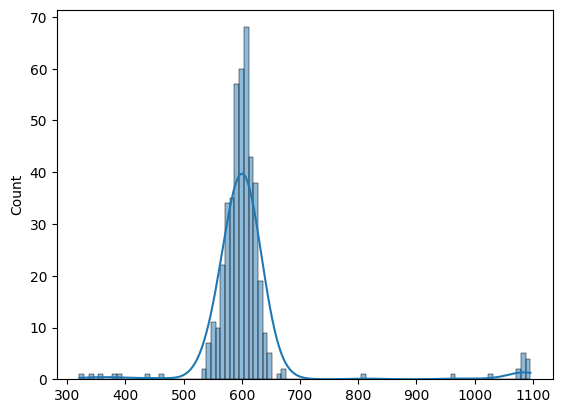

In [52]:
sns.histplot(data=pd.Series(doc_tokens), kde=True)

<Axes: ylabel='Count'>

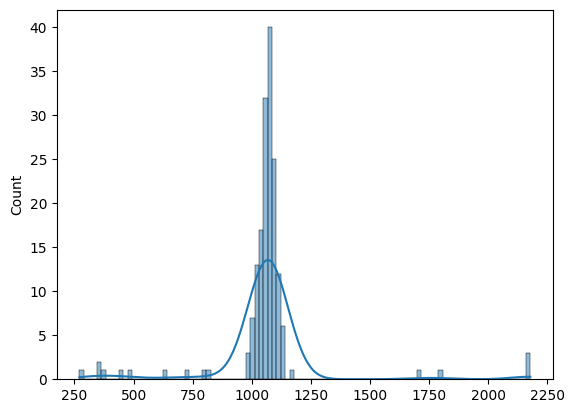

In [53]:
doc_tokens = []
for doc in character_splits:
    tokens  = count_tokens(doc.page_content)
    doc_tokens.append(tokens)
    
sns.histplot(data=pd.Series(doc_tokens), kde=True)

Mean token distirbution for token splits are close to 600 tokens while character splits are close to 1000. Even tough we stablished a higher chunk size, the algorithm checks the size of the first split and if it fullfills the requierement of split < chunk_size, it only adds a overlapping window based on the programmed algorithm

# Creating a Collection summary of all the policies

In [54]:
summary_df = pd.DataFrame().from_dict(text_dict, orient='index').reset_index(drop=False)
summary_df

,index,num_tokens,num_articles,text,title
0,dataset/raw_chunks/CAD220130244.pdf,1912,6,[exoneracion de pago de primas por fallecimien...,exoneracion de pago de primas por fallecimient...
1,dataset/raw_chunks/CAD320190121.pdf,3656,6,[clausula de invalidez permanente 80% por acci...,clausula de invalidez permanente 80% por accid...
2,dataset/raw_chunks/POL320160108.pdf,7987,20,[seguro individual de enfermedades graves\n\ni...,seguro individual de enfermedades graves\n\nin...
3,dataset/raw_chunks/POL320150503.pdf,16949,23,[poliza de seguro para prestaciones medicas de...,poliza de seguro para prestaciones medicas der...
4,dataset/raw_chunks/POL320190074.pdf,6806,15,[seguro para prestaciones medicas de alto cost...,seguro para prestaciones medicas de alto costo...
5,dataset/raw_chunks/CAD220130227.pdf,1901,6,[exoneracion de pago de primas por fallecimien...,exoneracion de pago de primas por fallecimient...
6,dataset/raw_chunks/POL320210063.pdf,4192,15,[seguro individual obligatorio de salud asocia...,seguro individual obligatorio de salud asociad...
7,dataset/raw_chunks/POL320180100.pdf,15782,23,[poliza de seguro para prestaciones medicas de...,poliza de seguro para prestaciones medicas der...
8,dataset/raw_chunks/POL320210210.pdf,6838,15,[seguro para prestaciones medicas de alto cost...,seguro para prestaciones medicas de alto costo...
9,dataset/raw_chunks/POL320130223.pdf,13783,19,[seguro colectivo complementario de salud\n\ni...,seguro colectivo complementario de salud\n\nin...


In [55]:
titles = summary_df['title'].to_list()
titles

['exoneracion de pago de primas por fallecimiento del asegurado\n\ntitular\n\nincorporada al deposito de polizas bajo el codigo cad220130244\n\n',
 'clausula de invalidez permanente 80% por accidente o enfermedad\n\nincorporada al deposito de polizas bajo el codigo cad320190121\n\nesta clausula adicional es parte integrante y accesoria de la poliza principal. en consecuencia, se regira por las condiciones generales de dicha poliza y por lo dispuesto en los siguientes ',
 'seguro individual de enfermedades graves\n\nincorporada al deposito de polizas bajo el codigo pol320160108\n\n',
 'poliza de seguro para prestaciones medicas derivadas de accidente\n\ny enfermedad\n\nincorporada al deposito de polizas bajo el codigo pol320150503\n\n',
 'seguro para prestaciones medicas de alto costo\n\nincorporada al deposito de polizas bajo el codigo pol320190074\n\n',
 'exoneracion de pago de primas por fallecimiento del asegurado\n\ntitular\n\nincorporada al deposito de polizas bajo el codigo cad22

In [56]:
metadata = summary_df[['index','num_tokens','num_articles']].rename({"index": "source"},axis=1).to_dict(orient='records')
metadata

[{'source': 'dataset/raw_chunks/CAD220130244.pdf',
  'num_tokens': 1912,
  'num_articles': 6},
 {'source': 'dataset/raw_chunks/CAD320190121.pdf',
  'num_tokens': 3656,
  'num_articles': 6},
 {'source': 'dataset/raw_chunks/POL320160108.pdf',
  'num_tokens': 7987,
  'num_articles': 20},
 {'source': 'dataset/raw_chunks/POL320150503.pdf',
  'num_tokens': 16949,
  'num_articles': 23},
 {'source': 'dataset/raw_chunks/POL320190074.pdf',
  'num_tokens': 6806,
  'num_articles': 15},
 {'source': 'dataset/raw_chunks/CAD220130227.pdf',
  'num_tokens': 1901,
  'num_articles': 6},
 {'source': 'dataset/raw_chunks/POL320210063.pdf',
  'num_tokens': 4192,
  'num_articles': 15},
 {'source': 'dataset/raw_chunks/POL320180100.pdf',
  'num_tokens': 15782,
  'num_articles': 23},
 {'source': 'dataset/raw_chunks/POL320210210.pdf',
  'num_tokens': 6838,
  'num_articles': 15},
 {'source': 'dataset/raw_chunks/POL320130223.pdf',
  'num_tokens': 13783,
  'num_articles': 19},
 {'source': 'dataset/raw_chunks/POL32020

# Creating Local Instance of Chroma

All the code is commented because at the end we were using the server implementation. Lines can be commented if a local instance wants to be created.

In [57]:
from langchain.embeddings import HuggingFaceEmbeddings, SentenceTransformerEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="distiluse-base-multilingual-cased-v1")
from langchain.vectorstores import Chroma

# db_summarized = Chroma.from_texts(
#     texts=titles,
#     metadatas=metadata,
#     persist_directory="chroma", 
#     embedding=embeddings,
#     collection_name='policies_info',
#     )
# db_summarized.persist()

# Loading it once created
# db_summarized = Chroma(persist_directory="chroma",
#     embedding_function=embeddings, 
#     collection_name="policies_info"
#     )

/home/andy/miniconda3/envs/chat_bot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [58]:
# db = Chroma.from_documents(token_splits,persist_directory="chroma", embedding=embeddings)
# db.persist()


# Loading it once created
# db = Chroma(
#     persist_directory="chroma",
#     embedding_function=embeddings, 
#     collection_name="langchain"
#     )

# Creating Chroma HTTP server for deployment

This instance requires cloning `Chroma` from github repo [https://github.com/chroma-core/chroma] and creating a custom Docker-compose & Dockerfile to set port parameters. Once finished, the docker compose inside the repo  can be joined with the docker-compose file of the app to have all services inside one single file (modifying the build context for chroma).

In [59]:
from chromadb.config import Settings
load_dotenv()

chroma_settings = Settings(chroma_api_impl=os.getenv('CHROMA_API_IMPL'),
                            chroma_server_host=os.environ.get('CHROMA_SERVER_HOST'),
                            chroma_server_http_port=os.environ.get('CHROMA_SERVER_HTTP_PORT'))


The data needs to be uploaded once, thus we comment the following code for data init

In [60]:
import time

start = time.time()

db_chunks = Chroma.from_documents(token_splits, 
                           embedding=embeddings, 
                           client_settings=chroma_settings,
                           collection_name=os.environ.get('CHROMA_CHUNKS_COLLECTION'))

db_index = Chroma.from_texts(
    texts=titles,
    metadatas=metadata, 
    embedding=embeddings,
    collection_name=os.environ.get('CHROMA_INDEX_COLLECTION'),
    client_settings=chroma_settings
    )

end = time.time()
time_taken = end - start

print("Time taken: ", time_taken)

ConnectionError: HTTPConnectionPool(host='localhost', port=8080): Max retries exceeded with url: /api/v1/collections (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f21823fab30>: Failed to establish a new connection: [Errno 111] Connection refused'))

## Testing re-connection

In [ ]:
db = Chroma(client_settings=chroma_settings,collection_name=os.environ.get('CHROMA_CHUNKS_COLLECTION'),embedding_function=embeddings)
db_summarized = Chroma(client_settings=chroma_settings,collection_name=os.environ.get('CHROMA_INDEX_COLLECTION'),embedding_function=embeddings)

# Querying the server DB

In [ ]:
# query it

start = time.time()


query = "Que cubre la poliza POL120190177 PÓLIZA DE ACCIDENTES PERSONALES / REEMBOLSO GASTOS MÉDICOS"
docs = db_summarized.similarity_search(query)

# print results
[doc.page_content for doc in docs]

end = time.time()
elapsed = end - start
print(f"Time taken to query: {elapsed} seconds")

Time taken to query: 0.34748291969299316 seconds


In [ ]:
start = time.time()

db.similarity_search(query)

end = time.time()
elapsed = end - start
print(f"Time taken to query: {elapsed} seconds")

Time taken to query: 0.2582516670227051 seconds


In [ ]:
# query it
# Testing n querys
n = 100
start = time.time()

for i in range(n):
    query = "Que cubre la poliza PÓLIZA DE ACCIDENTES PERSONALES / REEMBOLSO GASTOS MÉDICOS"
    docs = db_chunks.similarity_search_with_relevance_scores(query, k = 1)

    # print results
    # [doc for doc in docs]

end = time.time()
elapsed = end - start
print(f"Time taken to query: {elapsed} seconds, avg time per query: {elapsed/n} seconds")

Time taken to query: 5.988511800765991 seconds, avg time per query: 0.059885118007659915 seconds


# Testing Qdrant DB to check if server performance is better than chroma.

A qdrant server can be easly created with the following `docker_compose.yml` and running `docker-compose up --build`:

```python
version: "3.9"

services:
  qdrant:
    restart: unless-stopped
    image: qdrant/qdrant:v1.2.2
    ports:
    - 6333:6333
    volumes:
      - ./data/qdrant_storage:/qdrant/storage
    env_file:
      - .env   
``` 

In [168]:
from langchain.vectorstores import Qdrant

db_chunks = Qdrant.from_documents(token_splits, 
                           embedding=embeddings,
                           collection_name=os.environ.get('COLLECTION_CHUNKS'),
                           host="localhost",
                           prefer_grpc=True)

db_summarized = Qdrant.from_texts(
    texts=titles,
    metadatas=metadata, 
    embedding=embeddings,
    collection_name=os.environ.get('COLLECTION_SUMMARY'),
    host="localhost",
    prefer_grpc=True)

## Testing reconnection

In [178]:
import qdrant_client

client = qdrant_client.QdrantClient(
    "http://172.17.0.1:6333", prefer_grpc=True)

In [189]:
db_chunks= Qdrant(client=client, collection_name=os.environ.get('COLLECTION_CHUNKS'), embeddings=embeddings, distance_strategy="COSINE")
db_summarized = Qdrant(client=client, collection_name=os.environ.get('COLLECTION_SUMMARY'), embeddings=embeddings, distance_strategy="COSINE")

## Querying Qdrant db to test performance

In [64]:
# query it
# Testing n querys
n = 100
start = time.time()

for i in range(n):
    query = "Que cubre la poliza PÓLIZA DE ACCIDENTES PERSONALES / REEMBOLSO GASTOS MÉDICOS"
    docs = db.similarity_search_with_relevance_scores(query, k = 1)

    # print results
    # [doc for doc in docs]

end = time.time()
elapsed = end - start
print(f"Time taken to query: {elapsed} seconds, avg time per query: {elapsed/n} seconds")

Time taken to query: 9.275859594345093 seconds, avg time per query: 0.09275859594345093 seconds


In [180]:
db_summarized.similarity_search_with_relevance_scores(query, k = 1)

[(Document(page_content='poliza de accidentes personales / reembolso gastos medicos\n\nincorporada al deposito de polizas bajo el codigo pol120190177\n\n', metadata={'num_articles': 14, 'source': '/data_preloader/dataset/raw_chunks/POL120190177.pdf', 'num_tokens': 16037}),
  0.49248817563056946)]

In [190]:
db_chunks.similarity_search_with_relevance_scores(query,k=10)

[(Document(page_content='de ellos se señalan en las Condiciones Particulares de la póliza.\n\nLas coberturas que podrá otorgar la compañía de seguros en virtud de esta póliza, son las que se indican a continuación.\n\nA) BENEFICIO DE HOSPITALIZACIÓN\n\nB) BENEFICIO DE MATERNIDAD\n\nC) BENEFICIO AMBULATORIO\n\nD) BENEFICIO MEDICAMENTOS AMBULATORIOS\n\nE) BENEFICIO DE SALUD MENTAL\n\nF) BENEFICIOS ESPECIALES\n\nPara los efectos de tener derecho a los beneficios que emanan de estas coberturas, éstas deberán estar expresamente señaladas en las Condiciones Particulares de la póliza, en las cuales se establecerán además los porcentajes y límites de reembolso o pago correspondientes a cada una de ellas.\n\nA) BENEFICIO DE HOSPITALIZACIÓN:\n\nBajo este beneficio se cubren los gastos médicos incurridos en complemento de lo que cubra el sistema de salud previsional o de bienestar u otro seguro o convenio, de acuerdo a los porcentajes y límites de reembolso o pago definidos para este beneficio en

Even though Qdrant and chroma have similar query time on average, chroma documentation does not recommend to ouse it on deployments, servers or productions, thus we decised to sacrify those 0.01 secs for a more reliable db. Also it uses 30% less CPU memory while not in use.

# Creating and testing chains

In [66]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import AIMessage, HumanMessage, SystemMessage

from langchain.memory import ConversationBufferMemory
from langchain.callbacks.streaming_stdout_final_only import (
    FinalStreamingStdOutCallbackHandler,
)

In [67]:

llm = ChatOpenAI(temperature=0, model_name=MODEL_16K, max_tokens=4_000,streaming=True, callbacks=[FinalStreamingStdOutCallbackHandler()] ) # 4_000 max tokens in the request, 16k model to avoid context loss
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True
)

In [114]:
retriever_chunks = db.as_retriever(search_type="mmr", 
                            search_kwargs={"k": 10, 
                                           },
)

retriever_summary = db_summarized.as_retriever(search_type="similarity", 
                            search_kwargs={"k": 1},
)

## Testing retrieval chains

In [115]:
retriever_chunks.get_relevant_documents("Que cubre la poliza PÓLIZA DE ACCIDENTES PERSONALES / REEMBOLSO GASTOS MÉDICOS")

[Document(page_content='de ellos se señalan en las Condiciones Particulares de la póliza.\n\nLas coberturas que podrá otorgar la compañía de seguros en virtud de esta póliza, son las que se indican a continuación.\n\nA) BENEFICIO DE HOSPITALIZACIÓN\n\nB) BENEFICIO DE MATERNIDAD\n\nC) BENEFICIO AMBULATORIO\n\nD) BENEFICIO MEDICAMENTOS AMBULATORIOS\n\nE) BENEFICIO DE SALUD MENTAL\n\nF) BENEFICIOS ESPECIALES\n\nPara los efectos de tener derecho a los beneficios que emanan de estas coberturas, éstas deberán estar expresamente señaladas en las Condiciones Particulares de la póliza, en las cuales se establecerán además los porcentajes y límites de reembolso o pago correspondientes a cada una de ellas.\n\nA) BENEFICIO DE HOSPITALIZACIÓN:\n\nBajo este beneficio se cubren los gastos médicos incurridos en complemento de lo que cubra el sistema de salud previsional o de bienestar u otro seguro o convenio, de acuerdo a los porcentajes y límites de reembolso o pago definidos para este beneficio en 

Checking metadata filtering

In [117]:
db.as_retriever(search_type="similarity", 
                            search_kwargs={"k": 5, 
                                           "filter":{'source': 'dataset/raw_chunks/POL120190177.pdf'},
                                           }).get_relevant_documents("Que cubre la poliza PÓLIZA DE ACCIDENTES PERSONALES / REEMBOLSO GASTOS MÉDICOS")

[Document(page_content='PÓLIZA DE ACCIDENTES PERSONALES / REEMBOLSO GASTOS MÉDICOS\n\nIncorporada al Depósito de Pólizas bajo el código POL120190177\n\nARTÍCULO 1°: REGLAS APLICABLES AL CONTRATO Se aplicarán al presente contrato de seguro las disposiciones contenidas en los artículos siguientes y las normas legales de carácter imperativo establecidas en el título VIII, del Libro II, del Código de Comercio. Sin embargo, se entenderán válidas las estipulaciones contractuales que sean más beneficiosas para el asegurado o el beneficiario.\n\nARTÍCULO 2º: COBERTURA Y MATERIA ASEGURADA La Compañía Aseguradora reembolsará al asegurado o pagará directamente al prestador de salud los Gastos Médicos Razonables y Acostumbrados y Efectivamente Incurridos, una vez se haya otorgado y pagado la cobertura del sistema de salud previsional, seguros complementarios u otros beneficios contratados por el asegurado. Lo anterior, cuando al asegurado le ocurra un accidente durante la vigencia de esta póliza q

## Pivoting with templates and QA chains

In [71]:
from langchain.prompts import PromptTemplate
template ="""

Eres un agente comercial de polizas de la empresa QuePlan. Eres encargado de responder las preguntas de los clientes sobre las polizas de la empresa.
Si no sabes la respuesta, simplemente di que no lo sabes, no trates de inventar una respuesta. Si te falta información, pide al usuario que la proporcione en la siguiente pregunta.
Crea una respuesta con la suficiente información para que el usuario pueda entender la respuesta. No te limites a responder con un 'Sí' o un 'No', ni por extenso ni abreviado.
        
Pregunta: {question}
Contexto: {context}
Respuesta:"""
qa1_prompt = PromptTemplate(input_variables=["context", "question"],template=template)

In [72]:
# Run chain
from langchain.chains import RetrievalQA


qa_chain1 = RetrievalQA.from_chain_type(llm=llm, 
                                  retriever=retriever_chunks, 
                                  return_source_documents=True,
                                  chain_type_kwargs={"prompt": qa1_prompt}
)


In [118]:
question = "PÓLIZA DE ACCIDENTES PERSONALES / REEMBOLSO GASTOS MÉDICO"
result = qa_chain1(question)
result

{'query': 'PÓLIZA DE ACCIDENTES PERSONALES / REEMBOLSO GASTOS MÉDICO',
 'result': 'La póliza de Accidentes Personales / Reembolso Gastos Médicos de QuePlan cubre los gastos médicos razonables y acostumbrados que el asegurado haya incurrido una vez se haya otorgado y pagado la cobertura del sistema de salud previsional, seguros complementarios u otros beneficios contratados por el asegurado. Esta cobertura aplica cuando el asegurado sufre un accidente que requiere hospitalización y los gastos se realizan en los prestadores de salud determinados por la compañía aseguradora. Para que los gastos sean reembolsados, deben cumplirse los siguientes requisitos: el accidente debe haber ocurrido durante la vigencia de la póliza, los gastos deben haberse incurrido dentro del período de duración de reembolso, el monto de los gastos debe superar el deducible establecido en las Condiciones Particulares de la póliza, la suma de los reembolsos realizados durante la vigencia anual de la póliza no debe s

**Here we see a very big problem. The source documents for a very specific anwers do not belong to the same policy, thus the QA is generating responses out of the wrong data** 

# Creating our own QA chain with custom filters to avoid allusination

In [119]:
openai_template="""Eres un agente comercial de polizas de la empresa QuePlan. Eres encargado de responder las preguntas de los clientes sobre las polizas de la empresa.
        Si no sabes la respuesta, simplemente di que no lo sabes, no trates de inventar una respuesta. Si te falta información, pide al usuario que la proporcione en la siguiente pregunta.
        Crea una respuesta con la suficiente información para que el usuario pueda entender la respuesta. No te limites a responder con un 'Sí' o un 'No', ni por extenso ni abreviado.
        
        Utilizaras el siguiente contexto para responder la pregunta del usuario.
        {context}"""
human_template="{question}"
system_message_prompt = SystemMessagePromptTemplate.from_template(openai_template)
human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)
chat_prompt = ChatPromptTemplate.from_messages(
    [system_message_prompt, human_message_prompt]
)

In [120]:
question = "Necesito un resumen de la PÓLIZA DE ACCIDENTES PERSONALES / REEMBOLSO GASTOS MÉDICO"

First we query the index db with the summary of all the policies to retrieve the most similar

In [194]:
docs = db_summarized.similarity_search(question, k = 1)

In [196]:
docs

[Document(page_content='poliza de accidentes personales / reembolso gastos medicos\n\nincorporada al deposito de polizas bajo el codigo pol120190177\n\n', metadata={'num_articles': 14, 'source': '/data_preloader/dataset/raw_chunks/POL120190177.pdf', 'num_tokens': 16037})]

## Creating custom filtering function

In [197]:
def custom_filter_chain(question:str) -> str:
    docs = db_summarized.similarity_search(question, k = 1)
    most_likely_doc = docs[0].metadata['source']
    content = docs[0].page_content
    return most_likely_doc, content

In [198]:
custom_filter_chain(question)

('/data_preloader/dataset/raw_chunks/POL120190177.pdf',
 'poliza de accidentes personales / reembolso gastos medicos\n\nincorporada al deposito de polizas bajo el codigo pol120190177\n\n')

## Creating custom retriever

In [199]:
def custom_retriever(question):
    likely_doc, content = custom_filter_chain(question)
    retriever_all = db.as_retriever(
    search_type="similarity", search_kwargs={"k": 10, "filter":{"source": likely_doc}}
    )
    result = retriever_all.get_relevant_documents(question)
    return result

In [206]:
custom_retriever(question)

_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "failed to connect to all addresses; last error: UNKNOWN: ipv4:172.17.0.1:6334: Failed to connect to remote host: Connection refused"
	debug_error_string = "UNKNOWN:failed to connect to all addresses; last error: UNKNOWN: ipv4:172.17.0.1:6334: Failed to connect to remote host: Connection refused {created_time:"2023-08-01T20:15:33.02405377-05:00", grpc_status:14}"
>

## Creating custom QA

In [146]:
def custom_qa(question:str) -> dict[str,str,str]:
    response_dict = {}
    likely_doc , content = custom_filter_chain(question)
    docs = db.similarity_search(question, k = 10, filter={"source":likely_doc})
    # Stuffing the content in a single window
    doc_list = [doc.page_content for doc in docs]
    doc_list.append(content)
    chat_prompt_openai= chat_prompt.format_prompt(question=question, context="\n".join(doc_list)).to_messages()
    response = llm(chat_prompt_openai)
    response_dict['response'] = response
    response_dict['docs'] = docs
    response_dict['chat_prompt_openai'] = chat_prompt_openai
    return response_dict

Testing the prompt

In [147]:
chat_prompt_openai= chat_prompt.format_prompt(question=question, context="\n".join([doc.page_content for doc in docs])).to_messages()
chat_prompt_openai

[SystemMessage(content="Eres un agente comercial de polizas de la empresa QuePlan. Eres encargado de responder las preguntas de los clientes sobre las polizas de la empresa.\n        Si no sabes la respuesta, simplemente di que no lo sabes, no trates de inventar una respuesta. Si te falta información, pide al usuario que la proporcione en la siguiente pregunta.\n        Crea una respuesta con la suficiente información para que el usuario pueda entender la respuesta. No te limites a responder con un 'Sí' o un 'No', ni por extenso ni abreviado.\n        \n        Utilizaras el siguiente contexto para responder la pregunta del usuario.\n        poliza de accidentes personales / reembolso gastos medicos\n\nincorporada al deposito de polizas bajo el codigo pol120190177\n\n", additional_kwargs={}),
 HumanMessage(content='Necesito un resumen de la PÓLIZA DE ACCIDENTES PERSONALES / REEMBOLSO GASTOS MÉDICO', additional_kwargs={}, example=False)]

Testing the custom qa

In [84]:
result_test = custom_qa(question)
result_test["response"].content

'La póliza de Accidentes Personales / Reembolso Gastos Médicos de QuePlan ofrece cobertura para los gastos médicos razonables y acostumbrados que se incurran como resultado de un accidente durante la vigencia de la póliza. La compañía aseguradora reembolsará al asegurado o pagará directamente al prestador de salud los gastos médicos una vez se haya otorgado y pagado la cobertura del sistema de salud previsional, seguros complementarios u otros beneficios contratados por el asegurado.\n\nPara que los gastos sean reembolsados, deben cumplirse los siguientes requisitos: el accidente debe haber ocurrido durante la vigencia de la póliza, los gastos deben haberse incurrido dentro del período de duración de reembolso, el monto de los gastos debe superar el deducible establecido en las condiciones particulares de la póliza, la suma de los reembolsos de gastos realizados al asegurado no debe superar el monto máximo de gastos reembolsables establecido en las condiciones particulares, los gastos 

# Creating custom Agent

## QA Tools

In [203]:

# Directly answer the question
def qa_tool(question:str) -> str:
    response_dict = custom_qa(question)
    response = response_dict['response']
    return response.content

# Sends the context to the agent
def qa_tool2(question:str) -> str:
    likely_doc, content = custom_filter_chain(question)
    docs = db_chunks.similarity_search(question, k = 4, filter={"source":likely_doc})
    docs_list = [doc.page_content for doc in docs]
    docs_list.append(content)
    context="\n".join(docs_list)
    return context

In [86]:
def pretty_print(input_str):
    # Get the length of the input string
    length = len(input_str)

    # Initialize variables to keep track of the start and end index for each line
    start_index = 0
    end_index = 0

    while end_index < length:
        # Set the end index to the start index plus 100 characters
        end_index = start_index + 100
        
        # Check if the end index exceeds the length of the string
        if end_index >= length:
            end_index = length
        
        # Find the last space within the 100 characters
        last_space = input_str.rfind(' ', start_index, end_index)

        # If there is a space, print up to that space
        if last_space != -1 and last_space > start_index:
            print(input_str[start_index:last_space])
            start_index = last_space + 1
        else:
            # If there is no space, print the whole 100 characters
            print(input_str[start_index:end_index])
            start_index = end_index

In [87]:
pretty_print(result_test["response"].content)

La póliza de Accidentes Personales / Reembolso Gastos Médicos de QuePlan ofrece cobertura para los
gastos médicos razonables y acostumbrados que se incurran como resultado de un accidente durante la
vigencia de la póliza. La compañía aseguradora reembolsará al asegurado o pagará directamente al
prestador de salud los gastos médicos una vez se haya otorgado y pagado la cobertura del sistema de
salud previsional, seguros complementarios u otros beneficios contratados por el asegurado.

Para
que los gastos sean reembolsados, deben cumplirse los siguientes requisitos: el accidente debe
haber ocurrido durante la vigencia de la póliza, los gastos deben haberse incurrido dentro del
período de duración de reembolso, el monto de los gastos debe superar el deducible establecido en
las condiciones particulares de la póliza, la suma de los reembolsos de gastos realizados al
asegurado no debe superar el monto máximo de gastos reembolsables establecido en las condiciones
particulares, los gastos no 

## Web Search Tools

In [88]:
from langchain.tools import DuckDuckGoSearchRun , DuckDuckGoSearchResults

search = DuckDuckGoSearchRun()
def duck_duck_wrapper(query):
    search_results = search.run(f"{query}")
    return search_results 

In [89]:
duck_duck_wrapper("colombia")

"Colombia is the most populous nation of Spanish-speaking South America. More than one-third of its inhabitants live in the six largest metropolitan areas, of which Bogotá is the largest. The nation's political instability has been historically tied to the unequal distribution of wealth, and the illicit trade in drugs (mainly cocaine) remains ... Colombia (/ k ə ˈ l ʌ m b i ə / (), /-ˈ l ɒ m-/; Spanish: ()), officially the Republic of Colombia, is a country mostly in South America with insular regions in North America.The Colombian mainland is bordered by the Caribbean Sea to the north, Venezuela to the east and northeast, Brazil to the southeast, Ecuador and Peru to the south and southwest, the Pacific Ocean to the west, and ... Colombia is the world's top cocaine producer and exporter; is a source of heroin and marijuana; coca cultivation estimated at 234,000 hectares (ha) in 2021; pure cocaine production decreased to 972 metric tons in 2021; a major source of precursor or essential 

In [90]:
from langchain.agents import Tool
from langchain.agents import AgentType
from langchain.agents import initialize_agent
from langchain.chains import RetrievalQA

In [91]:
tools = [
    Tool(
        name = "Web Search",
        func=duck_duck_wrapper,
        description="useful for when you need to answer questions about current events, news or the current state of the world. Do not use it when asked about policies, in that case, use the policy search tool",
    ),
    Tool(
        name = "Policy Search",
        func=qa_tool2,
        description="useful for when you need to answer questions about an specific policy, in that case, use the policy search tool",
    ),
]


## Agent creation

In [92]:
from langchain.agents import Tool, AgentExecutor, LLMSingleActionAgent, AgentOutputParser
from langchain.prompts import StringPromptTemplate
from langchain import OpenAI, SerpAPIWrapper, LLMChain
from typing import List, Union
from langchain.schema import AgentAction, AgentFinish, OutputParserException
import re
from langchain.memory import ConversationBufferWindowMemory

In [93]:
memory = ConversationBufferWindowMemory(memory_key="chat_history", k=5)

In [94]:
# Set up the base template
template = """Eres Sabiduria Asegurada,un agente comercial de polizas de la empresa QuePlan, lastimosamente no sabes nada de informacion y dependes unicamente de las herramientas que te proporciona la empresa. No sabes nada de nada y si la herramienta no proporciona responde cordialmente que no sabes.
Eres encargado de responder las preguntas de los clientes sobre las polizas de la empresa.
Si no sabes la respuesta, simplemente di que no lo sabes, no trates de inventar una respuesta. Si te falta información, pide al usuario que la proporcione en la siguiente pregunta.
Crea una respuesta con la suficiente información para que el usuario pueda entender la respuesta. No te limites a responder con un 'Sí' o un 'No', ni por extenso ni abreviado.
        
Como agente tienes acceso a las siguientes herramientas:

{tools}

Utiliza unicamente el siguiente formato para tus respuestas:

Question: La pregunta que te hace el usuario
Thought: Piensa y razona como proceder para resolver la pregunta
Action: La mejor accion a realizar. Debe ser unicamente una de las siguientes [{tool_names}]
Action Input: Con base en la accion, que input necesita la accion para ejecutarse
Observation: El resultado de la accion
... (Este ciclo de Thought/Action/Action Input/Observation se puede repetir N veces hasta encontrar la respuesta final) 

Cuando encuentres la respuesta final, responde al usuario UNICAMENTE UNICAMENTE UNICAMENTE con la siguiente estructura:
Thought: Creo que se la respuesta final
Final Answer: La respuesta final que le daras al usuario. Empieza a responder la pregunta del usuario: Responde siempre de forma profesional y educada. Extiendete lo necesario
para una respuesta de calidad. SIEMPRE RESPONDE CON LA MAYOR CANTIDAD DE INFORMACION POSIBLE.


Historial de conversacion anterior:
{history}

Question: {input}
{agent_scratchpad}"""


# Set up a prompt template
class CustomPromptTemplate(StringPromptTemplate):
    # The template to use
    template: str
    # The list of tools available
    tools: List[Tool]

    def format(self, **kwargs) -> str:
        # Get the intermediate steps (AgentAction, Observation tuples)
        # Format them in a particular way
        intermediate_steps = kwargs.pop("intermediate_steps")
        thoughts = ""
        for action, observation in intermediate_steps:
            thoughts += action.log
            thoughts += f"\nObservation: {observation}\nThought: "
        # Set the agent_scratchpad variable to that value
        kwargs["agent_scratchpad"] = thoughts
        # Create a tools variable from the list of tools provided
        kwargs["tools"] = "\n".join([f"{tool.name}: {tool.description}" for tool in self.tools])
        # Create a list of tool names for the tools provided
        kwargs["tool_names"] = ", ".join([tool.name for tool in self.tools])
        return self.template.format(**kwargs)
    
prompt = CustomPromptTemplate(
    template=template,
    tools=tools,
    # This omits the `agent_scratchpad`, `tools`, and `tool_names` variables because those are generated dynamically
    # This includes the `intermediate_steps` variable because that is needed
    input_variables=["input", "intermediate_steps","history"]
)

class CustomOutputParser(AgentOutputParser):

    def parse(self, llm_output: str) -> Union[AgentAction, AgentFinish]:
        # Check if agent should finish
        if "Final Answer:" in llm_output:
            return AgentFinish(
                # Return values is generally always a dictionary with a single `output` key
                # It is not recommended to try anything else at the moment :)
                return_values={"output": llm_output.split("Final Answer:")[-1].strip()},
                log=llm_output,
            )
        # Parse out the action and action input
        regex = r"Action\s*\d*\s*:(.*?)\nAction\s*\d*\s*Input\s*\d*\s*:[\s]*(.*)"
        match = re.search(regex, llm_output, re.DOTALL)
        if not match:
            raise OutputParserException(f"Could not parse LLM output: `{llm_output}`")
        action = match.group(1).strip()
        action_input = match.group(2)
        # Return the action and action input
        return AgentAction(tool=action, tool_input=action_input.strip(" ").strip('"'), log=llm_output)
    
output_parser = CustomOutputParser()
# LLM chain consisting of the LLM and a prompt

llm_chain = LLMChain(llm=llm, prompt=prompt)
tool_names = [tool.name for tool in tools]

In [95]:
agent = LLMSingleActionAgent(
    llm_chain=llm_chain,
    output_parser=output_parser,
    stop=["\nObservation:"],
    allowed_tools=tool_names
)

Adding the memory manually to avoid errors with the Agent

In [96]:

agent_executor = AgentExecutor.from_agent_and_tools(agent=agent, tools=tools, verbose=False,handle_parsing_errors=True)

In [97]:
question = {'history': "", 'input': "Hola, me llamo Andres"}

In [101]:

answer= agent_executor(question)

 Hola Andrés, ¿en qué puedo ayudarte con respecto a las pólizas de QuePlan? Estoy aquí para responder tus preguntas y brindarte la información que necesites.

In [102]:
answer

{'history': '',
 'input': 'Hola, me llamo Andres',
 'output': 'Hola Andrés, ¿en qué puedo ayudarte con respecto a las pólizas de QuePlan? Estoy aquí para responder tus preguntas y brindarte la información que necesites.'}

In [278]:
history = []
history.append(f"Human: {question['input']}, AI: {answer}")

In [279]:
history

['Human: Hola, me llamo Andres, AI: Hola Andrés, ¿en qué puedo ayudarte hoy con respecto a las pólizas de QuePlan?']

In [282]:
user_input = "Que cubre el seguro PÓLIZA DE ACCIDENTES PERSONALES / REEMBOLSO GASTOS MÉDICO"
question = {f'history': {'\n'.join(history)}, 'input': f"{user_input}"}
question

{'history': {'Human: Hola, me llamo Andres, AI: Hola Andrés, ¿en qué puedo ayudarte hoy con respecto a las pólizas de QuePlan?'},
 'input': 'Que cubre el seguro PÓLIZA DE ACCIDENTES PERSONALES / REEMBOLSO GASTOS MÉDICO'}

In [284]:
answer = agent_executor.run(question)

 La póliza de Accidentes Personales / Reembolso Gastos Médicos cubre los Gastos Médicos Razonables y Acostumbrados y Efectivamente Incurridos en caso de accidente que requiera hospitalización. La compañía aseguradora reembolsará al asegurado o pagará directamente al prestador de salud los gastos médicos una vez se haya otorgado y pagado la cobertura del sistema de salud previsional, seguros complementarios u otros beneficios contratados por el asegurado. Los gastos deben ser originados por el accidente y realizados en los prestadores de salud determinados por el asegurador. La póliza establece requisitos como que el accidente ocurra durante la vigencia de la póliza, que los gastos se realicen dentro del período de duración de reembolso, que el monto de gastos supere el deducible establecido, que la suma de los reembolsos de gastos no supere el monto máximo de gastos reembolsables, que los gastos no provengan de una causa excluida y que las prestaciones médicas sean entregadas por los p

In [285]:
history.append(f"Human: {question['input']}, Sabidura Asegurada Asistente: {answer}")

In [286]:
history

['Human: Hola, me llamo Andres, AI: Hola Andrés, ¿en qué puedo ayudarte hoy con respecto a las pólizas de QuePlan?',
 'Human: Que cubre el seguro PÓLIZA DE ACCIDENTES PERSONALES / REEMBOLSO GASTOS MÉDICO, AI: La póliza de Accidentes Personales / Reembolso Gastos Médicos cubre los Gastos Médicos Razonables y Acostumbrados y Efectivamente Incurridos en caso de accidente que requiera hospitalización. La compañía aseguradora reembolsará al asegurado o pagará directamente al prestador de salud los gastos médicos una vez se haya otorgado y pagado la cobertura del sistema de salud previsional, seguros complementarios u otros beneficios contratados por el asegurado. Los gastos deben ser originados por el accidente y realizados en los prestadores de salud determinados por el asegurador. La póliza establece requisitos como que el accidente ocurra durante la vigencia de la póliza, que los gastos se realicen dentro del período de duración de reembolso, que el monto de gastos supere el deducible es

In [290]:
user_input = "cual es mi nombre"
question = {f'history': {'\n'.join(history)}, 'input': f"{user_input}"}
question

{'history': {'Human: Hola, me llamo Andres, AI: Hola Andrés, ¿en qué puedo ayudarte hoy con respecto a las pólizas de QuePlan?\nHuman: Que cubre el seguro PÓLIZA DE ACCIDENTES PERSONALES / REEMBOLSO GASTOS MÉDICO, AI: La póliza de Accidentes Personales / Reembolso Gastos Médicos cubre los Gastos Médicos Razonables y Acostumbrados y Efectivamente Incurridos en caso de accidente que requiera hospitalización. La compañía aseguradora reembolsará al asegurado o pagará directamente al prestador de salud los gastos médicos una vez se haya otorgado y pagado la cobertura del sistema de salud previsional, seguros complementarios u otros beneficios contratados por el asegurado. Los gastos deben ser originados por el accidente y realizados en los prestadores de salud determinados por el asegurador. La póliza establece requisitos como que el accidente ocurra durante la vigencia de la póliza, que los gastos se realicen dentro del período de duración de reembolso, que el monto de gastos supere el ded

In [291]:
agent_executor.run(question)

 Lo siento, pero no tengo acceso a esa información. Como agente virtual, no tengo la capacidad de conocer los nombres de los usuarios. ¿Hay algo más en lo que pueda ayudarte?

'Lo siento, pero no tengo acceso a esa información. Como agente virtual, no tengo la capacidad de conocer los nombres de los usuarios. ¿Hay algo más en lo que pueda ayudarte?'

In [428]:
question = "buscame en internet noticias sobre el coronavirus"
agent_executor.run(question)




> Entering new AgentExecutor chain...
Thought: El usuario está buscando noticias sobre el coronavirus, lo cual requiere utilizar la herramienta de búsqueda web.
Action: Web Search
Action Input: "noticias sobre el coronavirus"

Observation:La cada vez mayor conciencia sobre el autocuidado también implica un ... Últimas Noticias. Confirmaron que Carla Vizzotti permitió visitas discrecionales a internados por COVID-19 durante los ... El consumo de fármacos durante la COVID-19 se redujo a nivel mundial, sobre todo el de antibióticos, que cayó un 8,5 por ciento, según el estudio 'Impacto de la pandemia COVID-19 en la ... (CNN) --Un médico conocido por aconsejar a la gente sobre los riesgos del covid-19 se llevó una doble sorpresa: se contagió y acabó necesitando puntos de sutura por ello. El Dr. Robert Wachter ... Coronavirus Está pasando Ucrania Elecciones Generales Resultados 23J Feijóo Calculadora Pactos GRAN VÍA INCENDIO GRAN CANARIA Logroño Grand Prix Sandías IBEX Avance Consulte la 

'Aquí tienes algunas noticias sobre el coronavirus que encontré en internet. Parece que hay una variedad de temas relacionados con la pandemia, desde el autocuidado hasta el impacto en el consumo de fármacos. Te recomendaría leer los artículos completos para obtener más información sobre cada tema específico.'

In [429]:
question = "ahora sobre colombia"
agent_executor.run(question)



> Entering new AgentExecutor chain...
Thought: El cliente está preguntando sobre Colombia, por lo que puedo utilizar la herramienta de búsqueda web para obtener información actualizada sobre el país.

Action: Web Search
Action Input: "Colombia"


Observation:Colombia striker Linda Caicedo sent fear through her squad when she clutched her chest and collapsed during a training session on Thursday. The 18-year-old, who was diagnosed with cancer three ... Colombia, second-greatest biodiversity in the world Allow us to introduce you to the unique country of Colombia. A haven of biodiversity, with more than 50,000 species of animals and plants. Beautiful nature, exotic animals and a variety of orchid flowers will convince you that Colombia is one of the most extraordinary places on Earth. People demonstrate for the legalization of cannabis in Bogota, Colombia on May 6, 2023. On a recent Friday morning, about 200 coca and marijuana farmers gathered in the small town of Cajibio ... Colombia 

'Colombia es conocido por ser uno de los países con mayor biodiversidad en el mundo, albergando más de 50,000 especies de animales y plantas. Además, ha habido manifestaciones para la legalización del cannabis en Bogotá. Históricamente, la inestabilidad política del país ha estado relacionada con la desigual distribución de la riqueza, y el comercio ilícito de drogas, principalmente cocaína, sigue siendo un problema.'

In [430]:
question = "Que dice el articulo 5 de la poliza de seguros de salud?"
agent_executor.run(question)



> Entering new AgentExecutor chain...
Thought: No tengo información sobre el contenido específico del artículo 5 de la póliza de seguros de salud de QuePlan. Necesitaré utilizar la herramienta de búsqueda de políticas para encontrar la respuesta.

Action: Policy Search
Action Input: "Política de seguros de salud de QuePlan artículo 5"


Observation:la información que en él se indique, suscrito por el Asegurado y por el médico tratante, cuando corresponda.

b) Declaración del Asegurado respecto del sistema previsional o de salud al que se encuentre afiliado o adherido, Isapres, Fonasa, cajas de previsión, departamentos o servicios de bienestar, el Seguro Obligatorio de Accidentes Personales establecido en la Ley Nº 18.490, las Cajas de Compensación de Asignación Familiar, otros Seguros de Salud contratados en favor del Asegurado por otras instituciones, públicas o privadas, u otros seguros contratados en forma individual por él, que contemplen algún aporte, indemnización, reembolso o 

'El artículo 5 de la póliza de seguros de salud de QuePlan establece que el asegurado debe proporcionar una declaración respecto del sistema previsional o de salud al que esté afiliado, así como cualquier otro seguro de salud contratado por él. Además, el asegurado debe presentar los documentos que acrediten los gastos incurridos y los pagos realizados, así como cualquier aporte, indemnización, reembolso o bonificación efectuado o por efectuar en favor del asegurado. También se establece que el asegurado está obligado a proporcionar los antecedentes médicos y exámenes necesarios para acreditar la ocurrencia del evento cubierto por la póliza. El artículo también menciona el monto máximo de gastos reembolsables y el período de duración de reembolso. Además, se establece que la compañía aseguradora podrá solicitar pericias y exámenes médicos. Es importante destacar que esta respuesta se basa en la información proporcionada en el artículo 5 de la póliza de seguros de salud de QuePlan.'

In [431]:
question = "Que dice el articulo 5 del seguro individual de enfermedades graves?"
agent_executor.run(question)



> Entering new AgentExecutor chain...
Thought: Para responder a esta pregunta, debo utilizar la herramienta de búsqueda de políticas para encontrar el artículo 5 del seguro individual de enfermedades graves.

Action: Policy Search
Action Input: "Artículo 5 seguro individual enfermedades graves"


Observation:efálico causado o provocado por medios externos.

ARTICULO 5. OBLIGACIONES DEL ASEGURADO.

Conforme al artículo 524 del Código de Comercio, y demás deberes establecidos en las Condiciones Particulares de la póliza, las obligaciones del asegurado aplicables en este seguro son las siguientes:

1)(cid:9)Declarar sinceramente todas las circunstancias que solicite el asegurador para identificar la cosa asegurada y apreciar la extensión de los riesgos; 2)(cid:9)Pagar la prima en la forma y época pactadas; 3) (cid:9)Notificar al asegurador, tan pronto sea posible una vez tomado conocimiento, de la ocurrencia de cualquier hecho que pueda constituir o constituya un siniestro, y 4) (cid:9)

'Según el artículo 5 del seguro individual de enfermedades graves, las obligaciones del asegurado incluyen la declaración sincera de todas las circunstancias relevantes, el pago de la prima, la notificación de cualquier hecho que pueda constituir un siniestro y la acreditación del siniestro denunciado.'

# Creating a Class to wrap everything